# Model Quality Classifier for MPCs on pH Neutralization plant

> This notebook allows us to **predicte** the **quality of models** to be **used by an MPC controller** located in a pH Neutralization plant. More information about the in [1] [2]. A decision tree (**DT**) is trained and used to do so. In this cases the DT employees as **input features the validation results** from the proposed models. The **quality** of the model is calculated **based on the KPI of the control loop**. This notebook is the implementation of my master thesis [0].

 Reference: 
 
[0]. V. D. Reyes Dreke, “Desenvolvimento de uma ferramenta de validação de modelos para controladores preditivos baseados em modelos,” Universidade de Sao Paulo, 2019.

[1]. M. A. Pérez Serrano, V. D. Reyes Dreke, R. J. Correa de Godoy, and C. Garcia, “Sintonia e Avaliação de Controladores PID para uma Planta Piloto de Neutralização de pH,” in XIV Conferência Brasileira de Dinâmica,Controle e Aplicações, 2019, p. 7

[2]. C. Garcia and C. S. Morales Alvarado, “Comparison of statistical metrics and a new fuzzy method for validating linear models used in MPC controllers,” Ind. Eng. Chem. Res., vol. 57, no. September, pp. 366–3677, 2018 

[3]. K. Ogata, Ingeniería de control moderna, 5a ed. Madrid, España: Pearson Educación, 2010

[4]. H. Theil, Applied Economic Forecasting. Amsterdam: North Holland Publishing Company, 1966.

[5]. C. J. Willmott, S. M. Robeson, and K. Matsuura, “A refined index of model performance,” Int. J. Climatol., vol. 32, no. 13, pp. 2088–2094, Nov. 2012

[6]. D. M. Russell, “Error Measures for Comparing Transient Data: Part I: Development of a Comprehensive Error Measure,” in The Proceedings of the 68th Shock and Vibration Symposium, 1997, p. 25

[7]. K. Dvurecenska, S. Graham, E. Patelli, and E. A. Patterson, “A probabilistic metric for the validation of computational models,” R. Soc. Open Sci., vol. 5, p. 14, 2018

[8]. R. R. Rhinehart, “A watchdog for controller performance monitoring,” in Proceedings of 1995 American Control Conference - ACC’95, 1995, vol. 3, pp. 2239–2240.


### Importing the requerid libraries.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from scipy import signal
from sklearn import metrics
from sklearn import tree

### Importing my customized classes

In [24]:
from transferFunctions import TransferFunctionsClass
from dameMetric import DameMetricClass
from thresholdMetric import ThresholdMetricClass

## Defining the model to be classified

This program is desinged to deal with **transfer functions in *Laplace domain***. Especifically, it is used the **parametrics structure** of first and second order presented in [3]. The equations describing this systems are:

**1. Fisrt order** $$\frac{Y(s)}{U(s)}=\frac{K_p}{\tau_p*s+1}$$
**2. Second order** $$\frac{Y(s)}{U(s)}=\frac{K_p}{\tau_p^2*s^2+2*\tau_p*\zeta*s+1}$$
> Note: **The input values most be a real number**.


In [25]:
order_selection = input('Please insert (S) if you want a second order TF, or (F) for a first order TF:\n')
k_p_new = input('Please insert the value of K_p: \n') # default value = 1
k_p_new = float(k_p_new) * 0.5 # This is done because the amplitude step on the plant is equal to 0.5 pH
tau_new = float (input('Please insert the value of \N{greek small letter tau}_p: \n')) # default value = 70
if order_selection=='S':
    zeta_new = float(input('Please insert the value of \N{greek small letter zeta}: \n')) # default = 0.85
    first_order_enable = False
else:
    zeta_new = 0
    first_order_enable = True


Please insert (S) if you want a second order TF, or (F) for a first order TF:
F
Please insert the value of K_p: 
0.4
Please insert the value of τ_p: 
15


In [26]:
model_proposed = TransferFunctionsClass(tau=tau_new, k_p=k_p_new, zeta=zeta_new, selecting_order=first_order_enable)
# step_time [s] stands for the duration of the step,
# sample_time [s] stands for the sample time.
time, ph_predicted = model_proposed.simulated_validation_data(step_time=1500, sample_time=1)

## Visualization of the data from the pH Neutralization plant and the defined model.
 In this section, we load the plant response and we do a **comparison between the plant response and the proposed model**. The **data from the plant is storage in a Pandas's DataFrame**, which containts the data from the **setpoint** and the **process variable** of the plant.

In [27]:
ph_data_reference = pd.read_csv('Base de Datos Planta pH/pH_Data_Reference.csv', index_col=None)
ph_data_reference.columns = ['pH_PV', 'pH_SP']

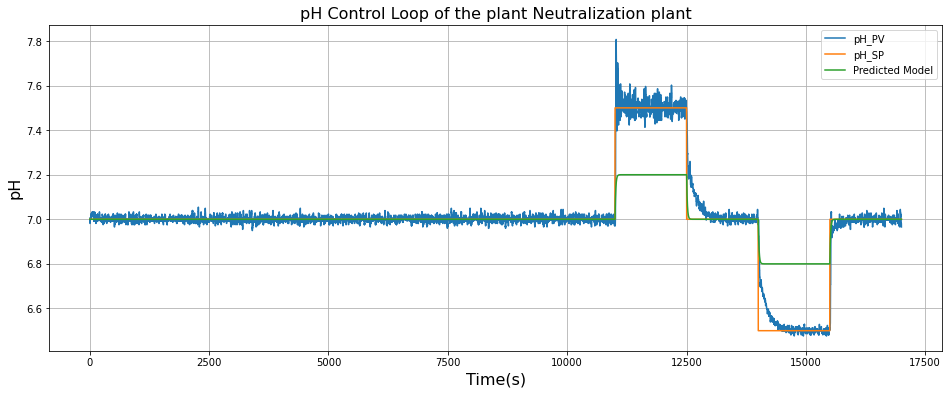

In [28]:
fig, axes = plt.subplots(figsize=(16, 6))
ph_data_reference['pH_PV'].plot()
ph_data_reference['pH_SP'].plot()
axes.plot(time, ph_predicted + 7,label='Predicted Model')
axes.set_xlabel('Time(s)', fontsize=16)
axes.set_ylabel('pH', fontsize=16)
axes.set_title("pH Control Loop of the plant Neutralization plant", fontsize=16)
axes.grid()
axes.legend()

## Validating the model predicted with the data from the pH plant Neutralization
In this section, we **validate** the defined models. To do this are used the classes **ThresholdMetricClass** and **DameMetricClass**. Both work with Pandas' Series as **inputs** and calculate different validation metrics. 
1. DameMetricClass
    * **Theil Inequality Coefficient** (TIC) [4]
    * **Willmott Index** (Willmott) [5]
    * **Russell Phase Component** (Russell_Pr) [6]
2. ThresholdMetricClass
    * **Dvurecenska metrics** (Dvure) [7]

Besides this metrics, we also estimated the **specification of transient response** of the model defined in [3].

In [29]:
rising_time, settling_time, overshoot = model_proposed.step_information(np.arange(30000)*0.1, rising_criteria=0.95, enable_ploting=False)
# We converts to numpy arrays because some limitations of the class ThresholdMetricClass and DameMetricClass dealing with the Pandas Series.
# This problem will be fixed on the next version.
temp_real_data = ph_data_reference['pH_PV'].to_numpy()
temp_reference_data = ph_data_reference['pH_SP'].to_numpy()
vm = ThresholdMetricClass(predicted_data=pd.Series(ph_predicted + 7), real_data=pd.Series(temp_real_data), reference_data=pd.Series(temp_reference_data))

dame = DameMetricClass(predicted_data=pd.Series(ph_predicted + 7), real_data=pd.Series(temp_real_data))


### Creating DataFrame
This **DataFrame will be the inputs of the decision tree**. It containts all validation metrics calculated before. Therefore, **with this information we generate our predictions**. 

In [30]:
# ['TIC', 'Willmott', 'Russell_Pr', 'Dvure', 'V_Tr', 'V_Ts', 'V_Mp']
x_feature_input = pd.DataFrame({
    'TIC':[dame.tic_index()],
    'Willmott':[dame.willmott_index()],
    'Russell_Pr':[dame.russell_index()[0]],
    'Dvure':[vm.dvurecesnka_metric()[0]],
    'V_Tr':[rising_time],
    'V_Ts':[settling_time],
    'V_Mp':[overshoot]
    
})
x_feature_input

,TIC,Willmott,Russell_Pr,Dvure,V_Tr,V_Ts,V_Mp
0,0.008973,0.682869,0.005702,14.003526,44.2,58.6,0


## Retrieving the Decision Tree
In this we  use the library call pickle. In this path, **we have various machine learning models** with the follow name structure Trained_[Name of the Algorithm]__[Variable Name]. **Therefore, make sure sure that ph is in the file name.**

In [31]:
file_name = 'Tree_Trained_pH_4' # By default we used this tree but you can select other. Just make sure that ph is in the file name
with open(file_name, 'rb') as f:
     tree_saved, validation_result = pickle.load(f)

## Cross-Validation result of the Decision Tree
In this section, we present some cross-validation result of the machine learning algorithm to be employed to predict the control response.

In [32]:
validation_result_dataframe = pd.DataFrame({
    'Accuracy': [validation_result[0]],
    'F1_score': [validation_result[1]],
    'ROC_AUC': [validation_result[2]]
})
# validation_result_dataframe
print('Accuracy: ' + str(validation_result[0]) +'\n')
print('F1 score:\n Class 1: ' + str(validation_result[1][0]) +
      '\n Class 2: '+ str(validation_result[1][1]) + 
      '\n Class 3: '+ str(validation_result[1][2]) +
      '\n Class 4: '+ str(validation_result[1][3]) +
      '\n Class 5: '+ str(validation_result[1][4]) +
      '\n Class 6: '+ str(validation_result[1][5]) +
      '\n Class 7: '+ str(validation_result[1][6]) + 
      '\n Class 8: '+ str(validation_result[1][7]) )
                                    
print('\nROC_AUC: ' + str(validation_result[2]))

Accuracy: 0.8691695108077361

F1 score:
 Class 1: 0.9329608938547486
 Class 2: 0.8859649122807017
 Class 3: 0.9208633093525179
 Class 4: 0.8776371308016878
 Class 5: 0.7412587412587412
 Class 6: 0.7603305785123967
 Class 7: 0.8490566037735849
 Class 8: 0.8287292817679558

ROC_AUC: 0.9679796229257287


Text(0, 0.5, 'Importance')

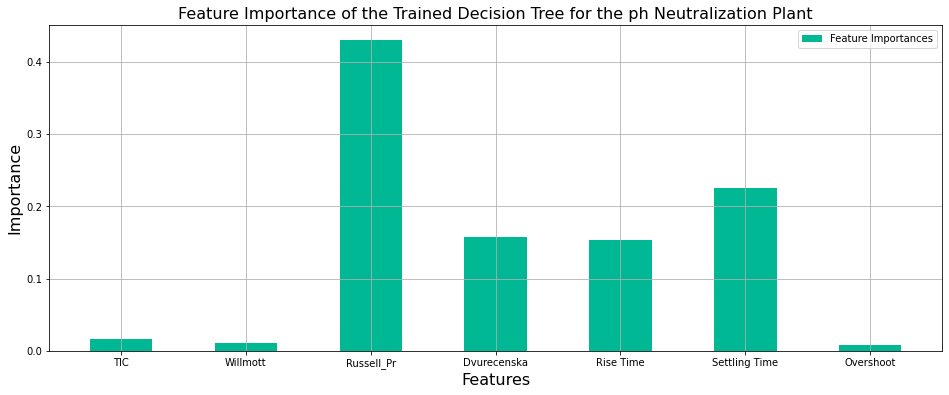

In [33]:
fig2, axes2 =  plt.subplots(figsize=(16, 6))
barWidth = 0.5
axes2.bar(['TIC', 'Willmott', 'Russell_Pr', 'Dvurecenska','Rise Time', 'Settling Time', 'Overshoot'], tree_saved.feature_importances_, width=barWidth, color='#00b894', label='Feature Importances')
axes2.legend()
axes2.grid()
axes2.set_title('Feature Importance of the Trained Decision Tree for the ph Neutralization Plant', fontsize=16)
axes2.set_xlabel('Features', fontsize=16)
axes2.set_ylabel('Importance', fontsize=16)


# Predicting the Quality of the Model

In [34]:
plant_predicted = tree_saved.predict(x_feature_input)
print('The predicted class of the model is: \n' + str(plant_predicted))

The predicted class of the model is: 
[1]


The **class means** that know we have an estimate of **how the control loop will behave** if the model proposed is used by the MPC. To classified this beheviour, we help us with the different KPIs, presented in the folliwing table.

**KPI estimated:**
- Settling Time 2% criterion (Ts) [3]
- Mean Square Error with the Reference (MESR) [0]
- Mean Square Error between Consequetive Data (MRSR) [0]
- Steady State Error (Ess) [3]
- Watchdog index (rwi) [0]
- Overshoot (Mp) [3]

| Class |Ts(s)       |MESR              |MRSR            |Ess       |rwi         |Mp(%)      |
|------ |------------| -----------------|----------------|----------|------------|-----------|
| 01    | $$200 \pm18$$  |  $$6.7e^{-4} \pm1.5e^{-5}$$ | $$7.8e^{-6} \pm6.1e^{-8}$$| $$0 \pm0$$  | $$9549 \pm385$$ | $$0.47 \pm0.58$$|
| 02    | $$252 \pm45$$  |  $$7.5e^{-4} \pm2.8e^{-5}$$ | $$7.9e^{-6} \pm1.7e^{-7}$$| $$0 \pm0$$  | $$9724 \pm643$$ | $$1.48 \pm0.61$$|
| 03    | $$383 \pm46$$  |  $$7.7e^{-4} \pm6.2e^{-5}$$ | $$8.0e^{-6} \pm4.8e^{-7}$$| $$0 \pm0$$  | $$9509 \pm1226$$ | $$1.55 \pm0.93$$|
| 04    | $$448 \pm62$$  |  $$8.1e^{-4} \pm1.3e^{-4}$$ | $$8.7e^{-6} \pm1.4e^{-6}$$| $$0 \pm0$$  | $$9700 \pm1706$$ | $$2.04 \pm1.29$$|
| 05    | $$541 \pm107$$  |  $$9.6e^{-4} \pm2.2e^{-4}$$ | $$9.6e^{-6} \pm1.6e^{-6}$$| $$0 \pm0$$ | $$8996 \pm2019$$ | $$1.68 \pm1.73$$|
| 06    | $$723 \pm78$$  |  $$1.1e^{-3} \pm1.9e^{-4}$$ | $$1.0e^{-5} \pm1.5e^{-6}$$| $$0 \pm0$$  | $$6856 \pm1466$$ | $$0.38 \pm1.2$$|
| 07    | $$839 \pm138$$  |  $$1.2e^{-3} \pm1.8e^{-4}$$ | $$1.1e^{-5} \pm2.3e^{-6}$$| $$0 \pm0$$  | $$6811 \pm1618$$ | $$0.87 \pm2.58$$|
| 08    | $$1221 \pm1094$$ |  $$5.6e^{-3} \pm0.19$$ | $$4.7e^{-5} \pm3e^{-4}$$| $$0.5\pm2.81e^{21}$$ | $$\infty$$   | $$31.9 \pm373$$|

#### Final Note
If you want to compare the prediction result with the real result of the plan, you can use the digital twin of the plant that is in the project on this link